In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
#==== SET UP & IMPORT LIBRARIES ======
import pandas as pd
import numpy as np

#VISUALISASI
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

#PREPROCESSING
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

#MODELLING
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

#METRICS
from sklearn.metrics import (
    recall_score, roc_auc_score, roc_curve,
    confusion_matrix, classification_report
)



In [35]:
#======= LOAD DATA  & EKSPLORASI AWAL =======
train = pd.read_csv("/content/drive/MyDrive/MyDataset /application_train.csv", delimiter=',')
test = pd.read_csv("/content/drive/MyDrive/MyDataset /application_test.csv", delimiter=',')
bureau = pd.read_csv("/content/drive/MyDrive/MyDataset /bureau.csv", delimiter=',')
prev = pd.read_csv("/content/drive/MyDrive/MyDataset /previous_application.csv", delimiter=',')
print(train.shape, test.shape, bureau.shape, prev.shape)

#TARGET DISTRIBUSI
print("\nTarget Distribution :")
print(train['TARGET'].value_counts(normalize=True))
print("\nTarget Count:")
print(train['TARGET'].value_counts())



(307511, 122) (48744, 121) (1716428, 17) (1670214, 37)

Target Distribution :
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Target Count:
TARGET
0    282686
1     24825
Name: count, dtype: int64



Target Distribution (Count):
TARGET
0    282686
1     24825
Name: count, dtype: int64

Target Distribution (Ratio):
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


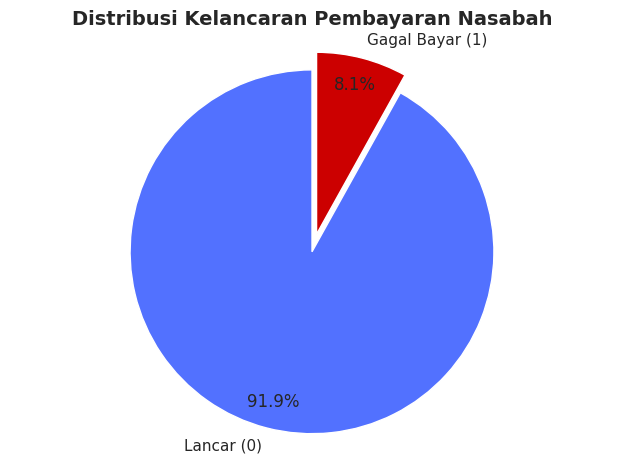


Jumlah kolom dengan missing value: 67


,Missing_Count,Missing_Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_MODE,214865,69.872297
COMMONAREA_AVG,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953


Jumlah fitur numerik     : 106
Jumlah fitur kategorikal : 16

Top 10 Categorical Features by Cardinality:


,0
ORGANIZATION_TYPE,58
OCCUPATION_TYPE,18
NAME_INCOME_TYPE,8
NAME_TYPE_SUITE,7
WALLSMATERIAL_MODE,7
WEEKDAY_APPR_PROCESS_START,7
NAME_FAMILY_STATUS,6
NAME_HOUSING_TYPE,6
NAME_EDUCATION_TYPE,5
FONDKAPREMONT_MODE,4


In [36]:
#======= EKSPLORASI DATA ANALYSIS (EDA) AWAL ========
# ---------------------------------------------------
#TARGET VARIABEL ANALYSIS
target_dist = train['TARGET'].value_counts()
target_ratio = train['TARGET'].value_counts(normalize=True)

print("\nTarget Distribution (Count):")
print(target_dist)

print("\nTarget Distribution (Ratio):")
print(target_ratio)


target_counts = train['TARGET'].value_counts()
labels = ['Lancar (0)', 'Gagal Bayar (1)']
colors = ['#5271ff', '#cc0000']
explode = (0.05, 0.05)
plt.pie(target_counts, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90,
        pctdistance=0.85, explode=explode)
plt.axis('equal')
plt.title('Distribusi Kelancaran Pembayaran Nasabah', fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig('pie_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

#MISSING VALUE ANALYSIS
def analyze_missing(df):
    missing = pd.DataFrame({
        'Missing_Count': df.isnull().sum(),
        'Missing_Percent': (df.isnull().sum() / len(df)) * 100
    })
    missing = missing[missing['Missing_Count'] > 0].sort_values(
        'Missing_Percent', ascending=False
    )
    return missing

missing_analysis = analyze_missing(train)

print(f"\nJumlah kolom dengan missing value: {missing_analysis.shape[0]}")
display(missing_analysis.head(15))

#Informasi data
num_cols = train.select_dtypes(include=['int64','float64']).columns
cat_cols = train.select_dtypes(include=['object']).columns

print("Jumlah fitur numerik     :", len(num_cols))
print("Jumlah fitur kategorikal :", len(cat_cols))

# Cardinality Categorical Features
cat_cardinality = train[cat_cols].nunique().sort_values(ascending=False)

print("\nTop 10 Categorical Features by Cardinality:")
display(cat_cardinality.head(10))


/tmp/ipython-input-1938753750.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('AGE_GROUP')['TARGET']
/tmp/ipython-input-1938753750.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


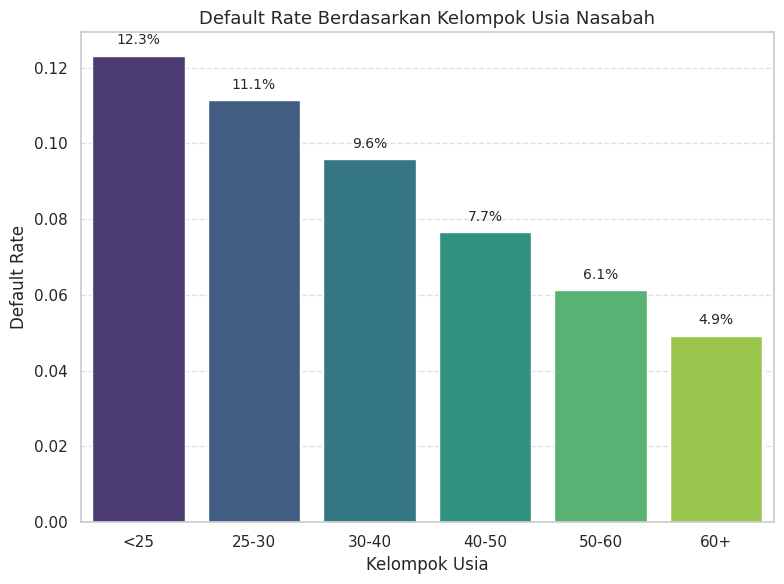

In [37]:
# =====================================================================
#  INSIGHT 1:
# Risiko Gagal Bayar Berdasarkan Kelompok Usia
# =====================================================================

# Buat kolom usia (tahun)
train['AGE_YEARS'] = (-train['DAYS_BIRTH']) / 365

# Kelompok usia
bins = [18, 25, 30, 40, 50, 60, 70]
labels = ['<25', '25-30', '30-40', '40-50', '50-60', '60+']
train['AGE_GROUP'] = pd.cut(
    train['AGE_YEARS'],
    bins=bins,
    labels=labels,
    right=False
)

# Hitung default rate
age_risk = (
    train
    .groupby('AGE_GROUP')['TARGET']
    .mean()
    .reset_index()
)

# Visualisasi
plt.figure(figsize=(8, 6))
sns.barplot(
    data=age_risk,
    x='AGE_GROUP',
    y='TARGET',
    palette='viridis'
)

plt.title('Default Rate Berdasarkan Kelompok Usia Nasabah', fontsize=13)
plt.xlabel('Kelompok Usia')
plt.ylabel('Default Rate')
plt.grid(axis='y', linestyle='--', alpha=0.6)


# Anotasi
for i, row in age_risk.iterrows():
    plt.text(
        i,
        row['TARGET'] + 0.003,
        f"{row['TARGET']*100:.1f}%",
        ha='center',
        fontsize=10
    )

plt.tight_layout()
plt.show()

#INSIGHT
#Nasabah berusia di bawah 25 tahun memiliki risiko gagal bayar tertinggi dengan default rate sebesar 12,3%, diikuti oleh kelompok usia 25–30 tahun dengan default rate 11,1%. Nilai ini sekitar 1,5 kali lebih tinggi dibandingkan nasabah berusia 40 tahun ke atas. Temuan ini mengindikasikan bahwa tingkat stabilitas finansial dan pengalaman kredit yang lebih rendah pada kelompok usia muda berkontribusi terhadap meningkatnya risiko gagal bayar.

/tmp/ipython-input-910908499.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['NAME_INCOME_TYPE', 'INCOME_GROUP'])['TARGET']


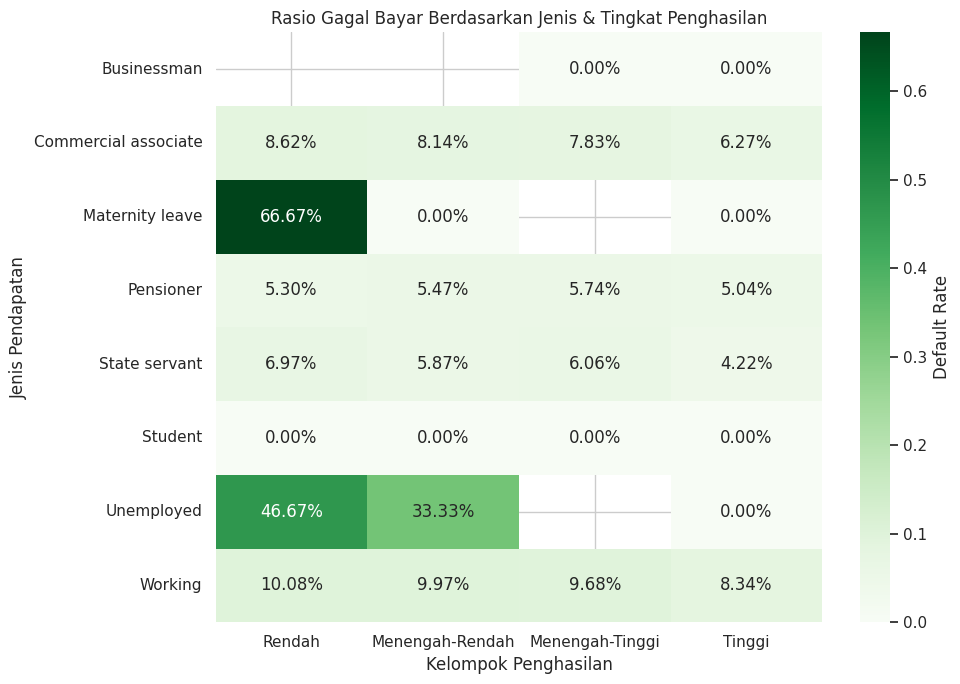

In [38]:
# =====================================================================
# INSIGHT #2: Tingkat & Stabilitas Penghasilan vs Risiko Gagal Bayar
# =====================================================================

df_insight = train.copy()

# Binning penghasilan
df_insight['INCOME_GROUP'] = pd.qcut(
    df_insight['AMT_INCOME_TOTAL'],
    q=4,
    labels=['Rendah', 'Menengah-Rendah', 'Menengah-Tinggi', 'Tinggi']
)

# Hitung default rate
income_risk = (
    df_insight
    .groupby(['NAME_INCOME_TYPE', 'INCOME_GROUP'])['TARGET']
    .mean()
    .reset_index()
)

# Visualisasi heatmap
plt.figure(figsize=(10, 7))
pivot = income_risk.pivot(
    index='NAME_INCOME_TYPE',
    columns='INCOME_GROUP',
    values='TARGET'
)

sns.heatmap(
    pivot,
    annot=True,
    fmt=".2%",
    cmap='Greens',
    cbar_kws={'label': 'Default Rate'}
)

plt.title('Rasio Gagal Bayar Berdasarkan Jenis & Tingkat Penghasilan')
plt.xlabel('Kelompok Penghasilan')
plt.ylabel('Jenis Pendapatan')
plt.tight_layout()
plt.show()

#INSIGHT 2
#Nasabah dengan tingkat penghasilan rendah dan sumber pendapatan yang tidak tetap menunjukkan risiko gagal bayar yang lebih tinggi dibandingkan nasabah dengan penghasilan lebih tinggi dan sumber pendapatan yang stabil.
#Secara khusus, kategori Unemployed pada kelompok penghasilan rendah hingga menengah-rendah memiliki risiko gagal bayar tertinggi dengan default rate berkisar antara 33%–47%, jauh lebih tinggi dibandingkan kategori pekerjaan lainnya.
#Temuan ini mengindikasikan bahwa stabilitas pendapatan merupakan faktor risiko yang sangat penting dalam penilaian kredit, bahkan lebih dominan dibandingkan tingkat penghasilan nominal.

In [39]:
#===============================================
# DATA PREPROCESSING & FEATURE ENGINEERING
#===============================================

#AGGREGASI DATA BUREAU
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'DAYS_CREDIT': ['min', 'max', 'mean'],
    'AMT_CREDIT_SUM': ['mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'AMT_CREDIT_MAX_OVERDUE': ['max'],
    'CNT_CREDIT_PROLONG': ['sum']
})

bureau_agg.columns = ['BUREAU_' + '_'.join(col) for col in bureau_agg.columns]
bureau_agg.reset_index(inplace=True)

print("Bureau aggregated shape:", bureau_agg.shape)

# AGGREGASI DATA PREVIOUS APPLICATION
prev['IS_APPROVED'] = (prev['NAME_CONTRACT_STATUS'] == 'Approved').astype(int)
prev['IS_REFUSED']  = (prev['NAME_CONTRACT_STATUS'] == 'Refused').astype(int)
prev['IS_CANCELED'] = (prev['NAME_CONTRACT_STATUS'] == 'Canceled').astype(int)

prev_agg = prev.groupby('SK_ID_CURR').agg({
    'AMT_ANNUITY': ['mean'],
    'AMT_APPLICATION': ['mean', 'sum'],
    'CNT_PAYMENT': ['min', 'max', 'mean'],
    'IS_APPROVED': ['mean', 'sum'],
    'IS_REFUSED': ['mean', 'sum'],
    'IS_CANCELED': ['mean', 'sum']
})

prev_agg.columns = ['PREV_' + '_'.join(col) for col in prev_agg.columns]
prev_agg.reset_index(inplace=True)

print("Previous application aggregated shape:", prev_agg.shape)

# JOIN DATA AGREGASI KE TRAIN & TEST
train_merged = train.merge(bureau_agg, on='SK_ID_CURR', how='left')
train_merged = train_merged.merge(prev_agg, on='SK_ID_CURR', how='left')

test_merged = test.merge(bureau_agg, on='SK_ID_CURR', how='left')
test_merged = test_merged.merge(prev_agg, on='SK_ID_CURR', how='left')

print("Train merged shape:", train_merged.shape)
print("Test merged shape :", test_merged.shape)


Bureau aggregated shape: (305811, 10)
Previous application aggregated shape: (338857, 13)
Train merged shape: (307511, 145)
Test merged shape : (48744, 142)


/tmp/ipython-input-656222155.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('REFUSED_GROUP')['TARGET']
/tmp/ipython-input-656222155.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


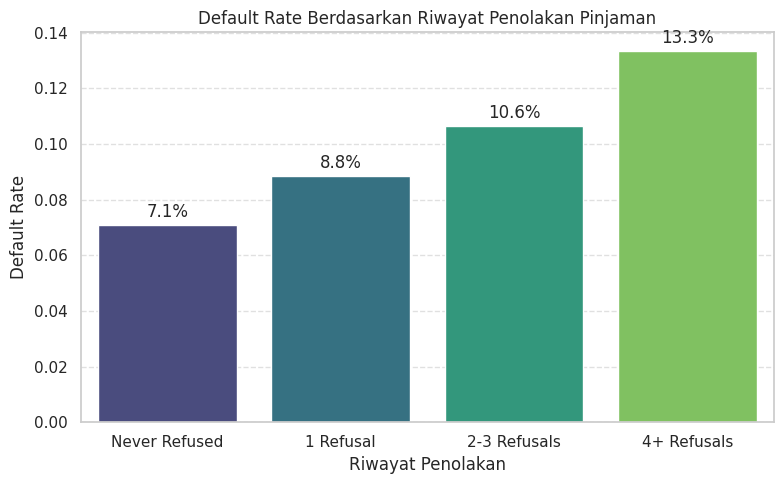

In [40]:
# =====================================================================
# INSIGHT #3: Riwayat Penolakan Pinjaman Sebelumnya
# =====================================================================

df_insight = train_merged.copy()

# Binning berdasarkan jumlah penolakan
df_insight['REFUSED_GROUP'] = pd.cut(
    df_insight['PREV_IS_REFUSED_sum'],
    bins=[-1, 0, 1, 3, 100],
    labels=['Never Refused', '1 Refusal', '2-3 Refusals', '4+ Refusals']
)

# Hitung default rate
refused_risk = (
    df_insight
    .groupby('REFUSED_GROUP')['TARGET']
    .mean()
    .reset_index()
)

# Visualisasi
plt.figure(figsize=(8, 5))
sns.barplot(
    data=refused_risk,
    x='REFUSED_GROUP',
    y='TARGET',
    palette='viridis'
)

plt.title('Default Rate Berdasarkan Riwayat Penolakan Pinjaman')
plt.xlabel('Riwayat Penolakan')
plt.ylabel('Default Rate')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Anotasi
for i, row in refused_risk.iterrows():
    plt.text(
        i,
        row['TARGET'] + 0.003,
        f"{row['TARGET']*100:.1f}%",
        ha='center'
    )

plt.tight_layout()
plt.show()

#INSIGHT
#Nasabah dengan riwayat penolakan pinjaman sebelumnya menunjukkan risiko gagal bayar yang secara konsisten lebih tinggi dibandingkan nasabah tanpa riwayat penolakan.
#Default rate meningkat hampir dua kali lipat secara bertahap seiring bertambahnya jumlah penolakan, dari 7,1% pada nasabah tanpa penolakan hingga 13,3% pada nasabah dengan lebih dari empat penolakan.
#Temuan ini mengindikasikan bahwa riwayat pengajuan pinjaman sebelumnya merupakan indikator risiko yang sangat kuat, karena mencerminkan kondisi finansial dan perilaku kredit nasabah secara historis.'''


In [41]:
# ============================================================
#  PREPROCESSING
# ============================================================

# --- Pisahkan target
y = train_merged['TARGET']
X = train_merged.drop(columns=['TARGET', 'SK_ID_CURR'], errors='ignore')
X_test = test_merged.drop(columns=['SK_ID_CURR'], errors='ignore')

# --- Identifikasi kolom numerik & kategorikal ---
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# --- Pisahkan kolom agregasi dan non-aggregasi ---
agg_cols = [c for c in num_cols if c.startswith(('BUREAU_', 'PREV_'))]
non_agg_num_cols = [c for c in num_cols if c not in agg_cols]

# --- Sinkronisasi kolom numeric non-agg ---
for col in non_agg_num_cols:
    if col not in X_test.columns:
        X_test[col] = np.nan

# --- Sinkronisasi kolom kategorikal ---
for col in cat_cols:
    if col not in X_test.columns:
        X_test[col] = np.nan

# -----------------------------
# Imputasi
# -----------------------------

# Aggregate numeric → isi dengan 0
X[agg_cols] = X[agg_cols].fillna(0)
X_test[agg_cols] = X_test[agg_cols].fillna(0)

# 2Non-aggregate numeric → median
num_imputer = SimpleImputer(strategy='median')
X[non_agg_num_cols] = num_imputer.fit_transform(X[non_agg_num_cols])
X_test[non_agg_num_cols] = num_imputer.transform(X_test[non_agg_num_cols])

# Kategorikal → mode
cat_imputer = SimpleImputer(strategy='most_frequent')
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])
X_test[cat_cols] = cat_imputer.transform(X_test[cat_cols])

# -----------------------------
# Label Encoding
# -----------------------------
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    le.fit(pd.concat([X[col].astype(str), X_test[col].astype(str)]))
    X[col] = le.transform(X[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

# -----------------------------
# Clip outliers (IQR method)
# -----------------------------
for col in non_agg_num_cols:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 3 * IQR
    upper = Q3 + 3 * IQR
    X[col] = X[col].clip(lower, upper)
    X_test[col] = X_test[col].clip(lower, upper)

# -----------------------------
# Final check
# -----------------------------
print("Train shape:", X.shape)
print("Test shape :", X_test.shape)
print("Missing values in train:", X.isnull().sum().sum())
print("Missing values in test :", X_test.isnull().sum().sum())


Train shape: (307511, 143)
Test shape : (48744, 142)
Missing values in train: 0
Missing values in test : 0


In [47]:
# ====================================================================================
# FINAL PREPROCESSING & FEATURE ENGINEERING
# ====================================================================================

# Menentukan kolom dokumen dan external source
doc_cols = [c for c in train_merged.columns if 'FLAG_DOCUMENT' in c]
ext_cols = [c for c in train_merged.columns if 'EXT_SOURCE' in c]

# Jalankan Feature Engineering pada KEDUA dataset (Train & Test)
for df in [train_merged, test_merged]:
    # FINANCIAL BURDEN
    df['LOAN_TO_INCOME'] = df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'] + 1)
    df['INSTALLMENT_BURDEN'] = df['AMT_ANNUITY'] / (df['AMT_INCOME_TOTAL'] + 1)
    df['ESTIMATED_TENURE'] = df['AMT_CREDIT'] / (df['AMT_ANNUITY'] + 1)
    df['EFFECTIVE_INCOME'] = df['AMT_INCOME_TOTAL'] / (df['CNT_FAM_MEMBERS'] + 1)

    # LIFE STABILITY
    df['CLIENT_AGE'] = (-df['DAYS_BIRTH'] / 365).round(1)
    df['JOB_DURATION'] = np.clip(-df['DAYS_EMPLOYED'] / 365, 0, 50)
    df['CAREER_RATIO'] = df['JOB_DURATION'] / (df['CLIENT_AGE'] + 1)

    # DOCUMENT COMMITMENT SCORE
    df['DOCUMENT_SCORE'] = df[doc_cols].sum(axis=1) / len(doc_cols)

    # EXTERNAL RISK COMPOSITE
    df['EXT_RISK_AVG'] = df[ext_cols].mean(axis=1)
    df['EXT_RISK_DIFF'] = (df['EXT_SOURCE_2'] - df['EXT_SOURCE_3']).abs()
    df['EXT_RISK_PROD'] = df[ext_cols].prod(axis=1)

    # RISK FLAG
    df['HIGH_INSTALLMENT_FLAG'] = (df['INSTALLMENT_BURDEN'] > 0.3).astype(int)

    # Clean up infinity
    df.replace([np.inf, -np.inf], 0, inplace=True)

# ---  SINKRONISASI ---

y = train_merged['TARGET']
X = train_merged.drop(columns=['TARGET', 'SK_ID_CURR'], errors='ignore')
X_test_final = test_merged.drop(columns=['SK_ID_CURR'], errors='ignore')

# PROTEKSI: Hanya ambil kolom yang ada di KEDUA dataset agar tidak KeyError
common_cols = X.columns.intersection(X_test_final.columns).tolist()
X = X[common_cols]
X_test_final = X_test_final[common_cols]

# 1. Label Encoding untuk kolom kategorikal yang tersisa
cat_cols = X.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    le = LabelEncoder()
    le.fit(pd.concat([X[col].astype(str), X_test_final[col].astype(str)]))
    X[col] = le.transform(X[col].astype(str))
    X_test_final[col] = le.transform(X_test_final[col].astype(str))

# 2. Final Imputation (Mengisi sisa NaN)
final_imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(final_imputer.fit_transform(X), columns=common_cols)
X_test_final = pd.DataFrame(final_imputer.transform(X_test_final), columns=common_cols)

# 3. Split Data (80:20)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.244597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17455
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 149
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482


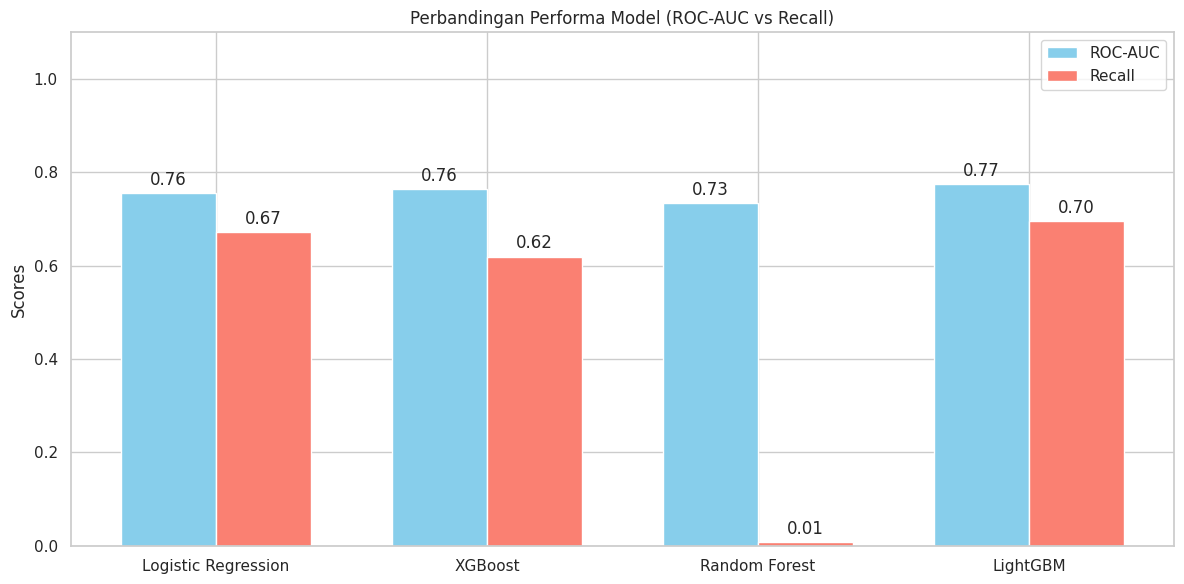

✅ Champion Model (ROC-AUC): LightGBM


In [50]:
# ====================================================================================
# 4. MODELLING
# ====================================================================================
# Penyiapan Data Khusus Logistic Regression (SMOTE + Scaling)
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_val_scaled = scaler.transform(X_val)

# --- Training 4 Model ---
lr_model = LogisticRegression(max_iter=1000, random_state=42).fit(X_train_scaled, y_train_bal)

ratio = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = XGBClassifier(scale_pos_weight=ratio, n_estimators=100, random_state=42, eval_metric='auc').fit(X_train, y_train)
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1).fit(X_train, y_train)
lgb_model = LGBMClassifier(n_estimators=100, is_unbalance=True, random_state=42, importance_type='gain').fit(X_train, y_train)

# ====================================================================================
# 5. EVALUATION & VISUALIZATION
# ====================================================================================
def evaluate_results(model, X_v, y_v):
    y_pred = model.predict(X_v)
    y_proba = model.predict_proba(X_v)[:, 1]
    return roc_auc_score(y_v, y_proba), recall_score(y_v, y_pred)

models_eval = {
    "Logistic Regression": (lr_model, X_val_scaled),
    "XGBoost": (xgb_model, X_val),
    "Random Forest": (rf_model, X_val),
    "LightGBM": (lgb_model, X_val)
}

results = {name: evaluate_results(m, x, y_val) for name, (m, x) in models_eval.items()}

# Visualisasi Bar Chart Vertikal
labels = list(results.keys())
auc_scores = [v[0] for v in results.values()]
recall_scores = [v[1] for v in results.values()]

x_axis = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bar1 = ax.bar(x_axis - width/2, auc_scores, width, label='ROC-AUC', color='skyblue')
bar2 = ax.bar(x_axis + width/2, recall_scores, width, label='Recall', color='salmon')

ax.set_ylabel('Scores')
ax.set_title('Perbandingan Performa Model (ROC-AUC vs Recall)')
ax.set_xticks(x_axis)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 1.1)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)

plt.tight_layout()
plt.show()

# Kesimpulan
best_model = max(results, key=lambda k: results[k][0])
print(f"Best Model (ROC-AUC): {best_model}")